In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
random_seed = 42
torch.manual_seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
np.random.seed(random_seed)
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'ARRG')))
from ARRG_macro import *

import wasserstein_loss
import deepsets_classifier
import importlib
importlib.reload(wasserstein_loss)
importlib.reload(deepsets_classifier)
from wasserstein_loss import *
from deepsets_classifier import *

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc

This notebook serves to verify that the DeepSets classifier can at least learn to distinguish by multiplicity alone, a statistic highly sensitive to the $a$ and $b$ parameters.

To do this we convert individual hadron data from and event as $ (p_x, p_y, p_z, E, m_h) \rightarrow 1$, and turn all pads into '0'.

## Deepsets Classifier

In [5]:
# Paths to the datasets on perlmutter
exp_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
sim_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e6.npy'

# Load the arrays
exp_hadrons = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons = np.load(sim_hadrons_PATH, mmap_mode="r")

Visiualize data set

Max multiplicity: 32


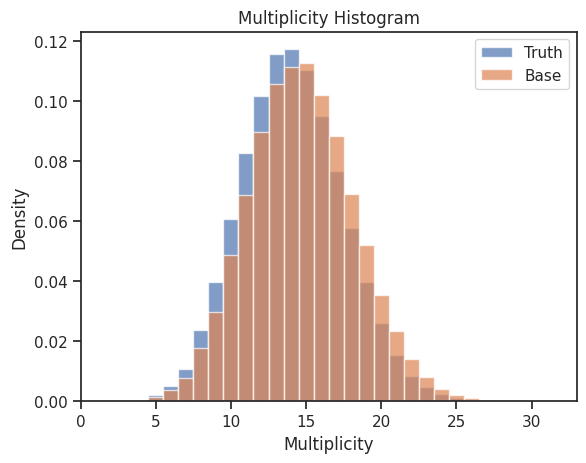

In [6]:
# Extract the hadron multiplicity
N=100000
exp_mult = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(N)])
sim_mult = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(N)])
min_mult = min(exp_mult.min(), sim_mult.min())
max_mult = max(exp_mult.max(), sim_mult.max())
# Calculate the bin edges
bins = int(max_mult - min_mult + 1)  # Number of bins, ensuring width of 1
bin_edges = np.arange(np.floor(min_mult) - 0.5, np.ceil(max_mult) + 0.5, 1)


print("Max multiplicity:", max(max(exp_mult), max(sim_mult)))
plt.hist(exp_mult[:N], bins=bin_edges, density=True, alpha=0.7, label="Truth")
plt.hist(sim_mult[:N], bins=bin_edges, density=True, alpha=0.7, label="Base")
plt.xlim((min_mult-1,max_mult+1))
plt.title("Multiplicity Histogram")
plt.xlabel("Multiplicity")
plt.ylabel("Density")
plt.legend()

In [28]:
# Paths to the datasets on perlmutter
exp_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
sim_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e6.npy'

# Load the arrays
exp_hadrons = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons = np.load(sim_hadrons_PATH, mmap_mode="r")

# Print dataset shapes
print('Experimental observable shape:', exp_hadrons.shape)
print('Simulated observable shape:', sim_hadrons.shape)

N_events = int(300000)
exp_obs = np.array([np.where(np.any(sub_arr != 0, axis=1), 1, 0) for sub_arr in exp_hadrons[:N_events]])
sim_obs = np.array([np.where(np.any(sub_arr != 0, axis=1), 1, 0) for sub_arr in sim_hadrons[:N_events]])
exp_obs_np = exp_obs[:, :, np.newaxis]
sim_obs_np = sim_obs[:, :, np.newaxis]

# Convert into torch objects
exp_obs = torch.Tensor(exp_obs_np.copy()).to(device)
sim_obs = torch.Tensor(sim_obs_np.copy()).to(device)
# Combine and split into training + validation and test sets
train_val_exp_obs, test_exp_obs = train_test_split(exp_obs, test_size=0.1, random_state=random_seed)
train_val_sim_obs, test_sim_obs = train_test_split(sim_obs, test_size=0.1, random_state=random_seed)
# Further split training + validation into separate training and validation sets
train_exp_obs, val_exp_obs = train_test_split(train_val_exp_obs, test_size=0.25, random_state=random_seed)  # 0.25 x 0.8 = 0.2
train_sim_obs, val_sim_obs = train_test_split(train_val_sim_obs, test_size=0.25, random_state=random_seed)

# Prepare data
batch_size=10000
train_exp_loader, train_sim_loader = prepare_data(train_exp_obs, train_sim_obs, batch_size=batch_size)
val_exp_loader, val_sim_loader = prepare_data(val_exp_obs, val_sim_obs, batch_size=batch_size)
test_exp_loader, test_sim_loader = prepare_data(test_exp_obs, test_sim_obs, batch_size=batch_size)

# Print dataset shapes
print('\nExperimental observable shape:', train_exp_obs.shape)
print('Simulated observable shape:', train_sim_obs.shape)

Experimental observable shape: (1000000, 50, 5)
Simulated observable shape: (1000000, 50, 5)

Experimental observable shape: torch.Size([202500, 50, 1])
Simulated observable shape: torch.Size([202500, 50, 1])


Number of learnable parameters: 1137


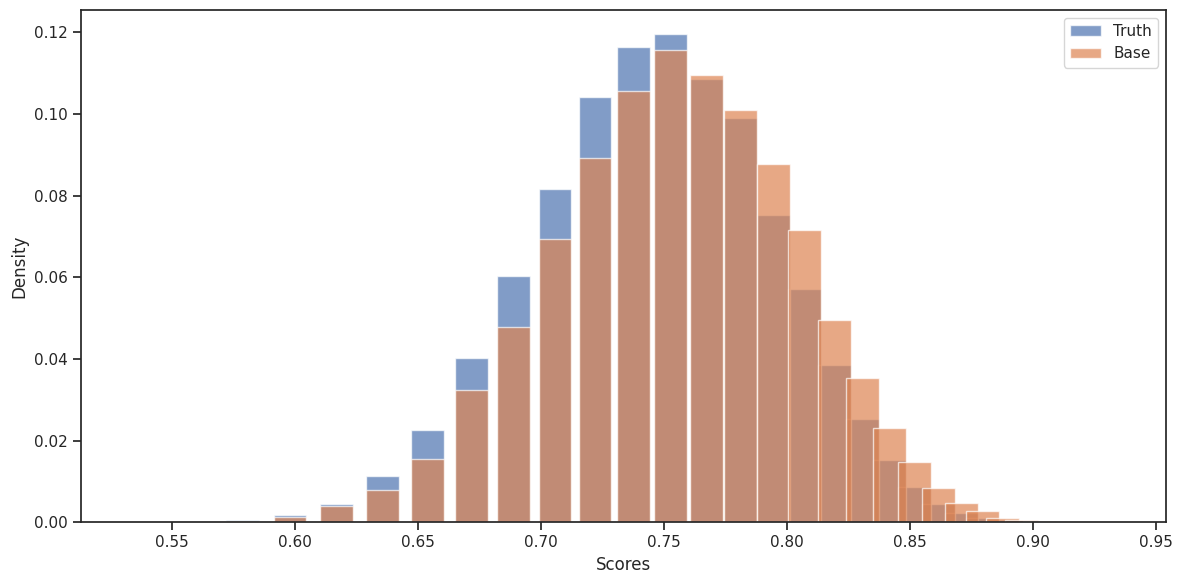

In [36]:
importlib.reload(deepsets_classifier)
from deepsets_classifier import *
torch.torch.manual_seed(34)
# Usage example:
input_dim = 1
phi_hidden_dim=16
rho_hidden_dim=16
phi_layers=3
rho_layers=3
dropout_prob=0.0
mask_pad=True
classifier = DeepSetsClassifier(input_dim=input_dim, phi_hidden_dim=phi_hidden_dim, rho_hidden_dim=rho_hidden_dim,
                                phi_layers=phi_layers, rho_layers=rho_layers,
                                dropout_prob=dropout_prob, mask_pad=mask_pad, momentum=0.5).to(device)
for m in classifier.modules():
    if isinstance(m, nn.Linear):
        # for multiplicty:
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('leaky_relu'))
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

classifier.eval()
test_exp_scores = torch.sigmoid(classifier(test_exp_obs)).cpu().detach().numpy()
test_sim_scores = torch.sigmoid(classifier(test_sim_obs)).cpu().detach().numpy()
mult_classifier_plot(test_exp_scores, test_sim_scores)

In [45]:
# Train the classifier
train=True
if train:
    epochs=2
    lr=1e-4
    classifier.train_classifier(train_exp_loader, train_sim_loader, val_exp_loader, val_sim_loader, 
                                device=device, num_epochs=epochs, learning_rate=lr)
    #torch.save(classifier.state_dict(), "deepsets_classifier.pth")
else:
    classifier.load_state_dict(torch.load('deepsets_classifier.pth'))
    classifier.eval()

Epoch [1/2]
Train Loss: 0.69279, Train Exp Loss: 0.7129, Train Sim Loss: 0.6727
Val Loss: 0.69381, Val Exp Loss: 0.7276, Val Sim Loss: 0.6600
Average score: 0.32207

Epoch [2/2]
Train Loss: 0.69237, Train Exp Loss: 0.7121, Train Sim Loss: 0.6726
Val Loss: 0.69340, Val Exp Loss: 0.7124, Val Sim Loss: 0.6744
Average score: 0.327



Text(0, 0.5, 'Validation Loss')

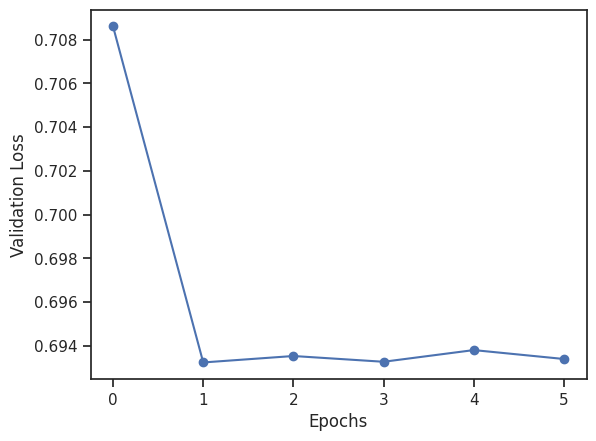

In [46]:
plt.plot(classifier.val_loss, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")

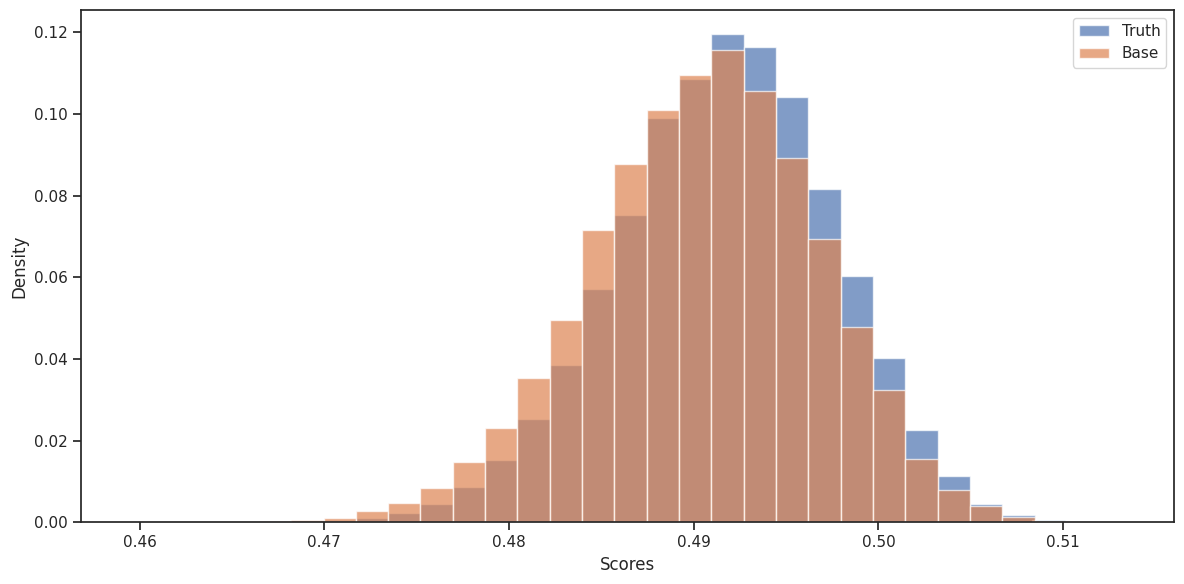

In [47]:
# Evaluate the model on test set
# evaluate_model(classifier, test_exp_loader, test_sim_loader)
classifier.eval()
test_exp_scores = torch.sigmoid(classifier(test_exp_obs)).cpu().detach().numpy()
test_sim_scores = torch.sigmoid(classifier(test_sim_obs)).cpu().detach().numpy()
    
mult_classifier_plot(test_exp_scores, test_sim_scores)

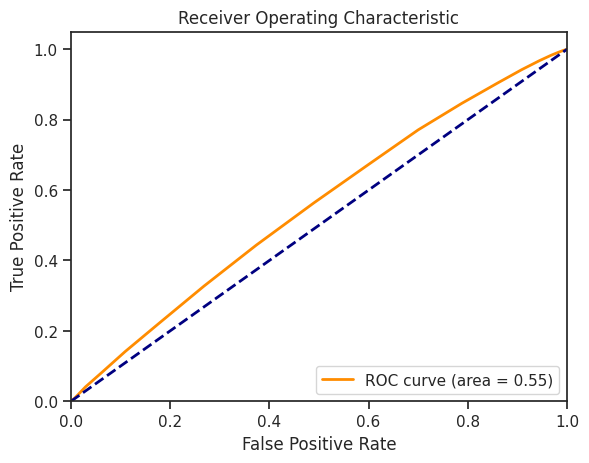

In [48]:
# Create labels
y_true = np.concatenate([np.ones_like(test_exp_scores), np.zeros_like(test_sim_scores)])
y_scores = np.concatenate([test_exp_scores, test_sim_scores])

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Wasserstein Weight Tuning

In [49]:
sim_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_finalTwo_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'
sim_fPrel_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_finalTwo_fPrel_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'

# Load the arrays
exp_hadrons       = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons       = np.load(sim_hadrons_PATH, mmap_mode="r")
sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")
sim_fPrel         = np.load(sim_fPrel_PATH, mmap_mode = "r")
# Extract the hadron multiplicity
exp_obs = exp_hadrons # exp_obs = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(exp_hadrons.shape[0])])
sim_obs = sim_hadrons # sim_obs = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(sim_hadrons.shape[0])])
# Print dataset shapes
print('Experimental observable shape:', exp_hadrons.shape)
print('Simulated observable shape:', sim_hadrons.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

# Restrict to a subset of the full dataset (for memory)
N_events = min(len(sim_accept_reject), 100000)
print("N_events:", N_events)
sim_accept_reject = torch.Tensor(sim_accept_reject[0:N_events].copy()).to(device) # z values
# Check the accepted z-values, if z == 1 reduce it by epsilon (a very nasty bug to find).
# The a-coefficient when computing the likelihood has a term propotional to log(1-z). If 
# z = 1, this term diverges to -inf and completely destroys the backward pass.
epsilon = 1e-5
sim_accept_reject[sim_accept_reject == 1] = 1 - epsilon
sim_fPrel = torch.Tensor(sim_fPrel[0:N_events].copy()).to(device)
# Convert into torch objects
exp_obs = np.array([np.where(np.any(sub_arr != 0, axis=1), 1, 0) for sub_arr in exp_obs[:N_events]])
sim_obs = np.array([np.where(np.any(sub_arr != 0, axis=1), 1, 0) for sub_arr in sim_obs[:N_events]])
exp_obs_np = exp_obs[:, :, np.newaxis]
sim_obs_np = sim_obs[:, :, np.newaxis]
exp_obs = torch.Tensor(exp_obs_np.copy()).to(device)
sim_obs = torch.Tensor(sim_obs_np.copy()).to(device)

# Print dataset shapes
print('Experimental observable shape:', exp_obs.shape)
print('Simulated observable shape:', sim_obs.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

Experimental observable shape: (1000000, 50, 5)
Simulated observable shape: (1000000, 50, 5)
Simulated z shape: (50000, 105, 101)
Simulated fPrel shape: (50000, 105, 100)
N_events: 50000
Experimental observable shape: torch.Size([50000, 50, 1])
Simulated observable shape: torch.Size([50000, 50, 1])
Simulated z shape: torch.Size([50000, 105, 101])
Simulated fPrel shape: torch.Size([50000, 105, 100])


In [50]:
params_base = torch.tensor([0.72, 0.88])
params_init = torch.tensor([0.7, 0.9])
over_sample_factor = 10.0
# initialize weight module
weight_nexus = LundWeight(params_base, params_init, over_sample_factor = over_sample_factor).to(device)

n = 10
print(weight_nexus(sim_accept_reject[:n], sim_fPrel[:n]))

tensor([1.0491, 1.1027, 0.9518, 1.1018, 1.0195, 0.8884, 0.8477, 1.0835, 1.0926,
        0.8541], device='cuda:0', grad_fn=<MulBackward0>)


In [51]:
class CombinedDataset(Dataset):
    def __init__(self, exp_obs, sim_obs, sim_fPrel, sim_accept_reject):
        self.exp_obs = exp_obs
        self.sim_obs = sim_obs
        self.sim_fPrel = sim_fPrel
        self.sim_accept_reject = sim_accept_reject
        assert len(exp_obs) == len(sim_obs) == len(sim_fPrel) == len(sim_accept_reject), "All inputs must have the same length"

    def __len__(self):
        return len(self.exp_obs)

    def __getitem__(self, idx):
        return {
            'exp_scores': self.exp_obs[idx],
            'sim_scores': self.sim_obs[idx],
            'sim_fPrel': self.sim_fPrel[idx],
            'sim_accept_reject': self.sim_accept_reject[idx],
        }

# Assuming you've already processed your data as described in your code snippet
# and have exp_obs, sim_obs, sim_accept_reject, and sim_mT ready

# Create the dataset
exp_scores = classifier.forward(exp_obs)
sim_scores = classifier.forward(sim_obs)
sar_size = sim_accept_reject.shape[0]
dataset = CombinedDataset(exp_scores[:sar_size], sim_scores[:sar_size], sim_fPrel, sim_accept_reject)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))  # 90% for training
val_size = len(dataset) - train_size  # no worry of overfittitng, remove validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 10000  # You can adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [53]:
class Wasserstein_Tuner:
    def __init__(self, classifier, weight_nexus, learning_rate=0.001):
        self.classifier = classifier
        self.weight_nexus = weight_nexus
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam([self.weight_nexus.params_a, self.weight_nexus.params_b], lr=self.learning_rate)
        self.wasserstein_loss = WassersteinLoss()
        self.param_history = []

    def train(self, train_loader: DataLoader, val_loader: DataLoader, num_epochs: int = 10, verbose=False):
        print("Beginning parameter tuning...")
        print(f"Initial (a, b): ({self.weight_nexus.params_a.item():.4f}, {self.weight_nexus.params_b.item():.4f})")
        for epoch in range(num_epochs):
            # Training loop
            train_loss = 0.0
            self.weight_nexus.train()
            self.optimizer.zero_grad()  # Zero the gradients before starting the epoch

            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
                # Unpack the batch
                exp_scores_data = batch['exp_scores']
                sim_scores_data = batch['sim_scores']
                sim_accept_reject_data = batch['sim_accept_reject']
                sim_fPrel_data = batch['sim_fPrel']
                exp_scores_data.detach()
                sim_scores_data.detach()
                sim_accept_reject_data.detach()
                sim_fPrel_data.detach()

                # Calculate weights
                weights = self.weight_nexus(sim_accept_reject_data, sim_fPrel_data)

                # Calculate Wasserstein distance
                loss = self.wasserstein_loss(exp_scores_data, sim_scores_data, y_weights=weights)
                # print("wd =", loss.item())

                # Backpropagate to accumulate gradients
                loss.backward()

                weights.detach()

                # Record current values of params_a and params_b
                self.param_history.append({
                    'epoch': epoch + 1,
                    'params_a': self.weight_nexus.params_a.item(),
                    'params_b': self.weight_nexus.params_b.item()
                })

                train_loss += loss.item()

            # After all batches in the epoch, update parameters
            self.optimizer.step()
            # Print current values of params_a and params_b
            # Zero gradients for the next epoch
            self.optimizer.zero_grad()

            # Print training loss for this epoch
            avg_train_loss = train_loss / len(train_loader)
            if verbose: 
                print(f"Current (a, b): ({self.weight_nexus.params_a.item():.6f}, {self.weight_nexus.params_b.item():.6f})")
                print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4g}")

            # Validation loop
            self.weight_nexus.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    # Unpack the batch
                    exp_scores_data = batch['exp_scores']
                    sim_scores_data = batch['sim_scores']
                    sim_accept_reject_data = batch['sim_accept_reject']
                    sim_fPrel_data = batch['sim_fPrel']

                    # Calculate weights
                    weights = self.weight_nexus(sim_accept_reject_data, sim_fPrel_data)

                    # Calculate Wasserstein distance
                    loss = self.wasserstein_loss(exp_scores_data, sim_scores_data, y_weights=weights)

                    val_loss += loss.item()

            # Print validation loss for this epoch
            avg_val_loss = val_loss / len(val_loader)
            if verbose: print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4g}")

        return self.weight_nexus

    def Wasserstein_flow(self, flow_loader: DataLoader, a_b_init_grid):
        """
        Generate gradient flow data using the same loss and dataloader as in training.
        """
        # Initialize gradient tensor
        a_b_gradient = torch.zeros(len(a_b_init_grid), 2)
        loss_grid = torch.zeros(len(a_b_init_grid))
        init_counter = 0

        for a_b_init in tqdm(a_b_init_grid, ncols=100, desc="Wasserstein Flow"):
            # Initialize new weight module with different initial parameters
            self.weight_nexus = LundWeight(params_base, a_b_init, over_sample_factor=over_sample_factor)
            self.weight_nexus.eval()  # Set the model to evaluation mode

            a_b_gradient_i = torch.zeros(2)
            for batch in flow_loader:
                # Unpack the batch
                sim_accept_reject_data = batch['sim_accept_reject']
                sim_fPrel_data = batch['sim_fPrel']
                sim_scores_data = batch['sim_scores']
                exp_scores_data = batch['exp_scores']

                # Zero the gradients
                self.optimizer.zero_grad()

                # Calculate weights
                weights = self.weight_nexus(sim_accept_reject_data, sim_fPrel_data)

                # Calculate Wasserstein distance
                loss = self.wasserstein_loss(exp_scores_data, sim_scores_data, y_weights=weights)

                # Backpropagation to compute gradients
                loss.backward(retain_graph=True)

                # Extract gradients for params_a and params_b
                a_b_gradient_i[0] += self.weight_nexus.params_a.grad.clone().detach()
                a_b_gradient_i[1] += self.weight_nexus.params_b.grad.clone().detach()

            # Average gradients across batches
            a_b_gradient_i /= len(flow_loader)

            # Write to the master gradient tensor
            a_b_gradient[init_counter] = a_b_gradient_i.clone()
            loss_grid[init_counter] = loss.clone().detach()
            init_counter += 1

        # Convert the gradient tensor to a numpy array
        a_b_gradient = a_b_gradient.numpy()
        loss_grid = loss_grid.numpy()
        return a_b_gradient, loss_grid
    
    def set_learning_rate(self, new_lr: float):
        self.learning_rate = new_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr

    def get_current_parameters(self):
        return {
            'params_a': self.weight_nexus.params_a.item(),
            'params_b': self.weight_nexus.params_b.item()
        }

def a_b_grid(x_range, y_range, n_points):
    """
    Creates a grid of values within a two-dimensional range and returns it in a flattened tensor.
    """
    # Create linearly spaced points for each range
    x_points = torch.linspace(x_range[0], x_range[1], n_points)
    y_points = torch.linspace(y_range[0], y_range[1], n_points)

    # Create a meshgrid from the x and y points
    x_grid, y_grid = torch.meshgrid(x_points, y_points, indexing='ij')

    # Flatten the grid and stack the coordinates
    grid_flattened = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

    return grid_flattened

In [54]:
importlib.reload(wasserstein_loss)
from wasserstein_loss import WassersteinLoss, WassersteinLoss_POT

params_base = torch.tensor([0.72, 0.88])
params_init = torch.tensor([0.71, 0.881])
# True parameters (0.68, 0.98)
over_sample_factor = 10.0
# initialize weight module
weight_nexus = LundWeight(params_base, params_init, over_sample_factor = over_sample_factor)

tuner = Wasserstein_Tuner(classifier, weight_nexus, learning_rate=0.005)
tuner.train(train_loader, val_loader, num_epochs=20, verbose=False)

Beginning parameter tuning...
Initial (a, b): (0.7100, 0.8810)


LundWeight()

Text(0.5, 1.0, 'Parameters (a,b) over epochs')

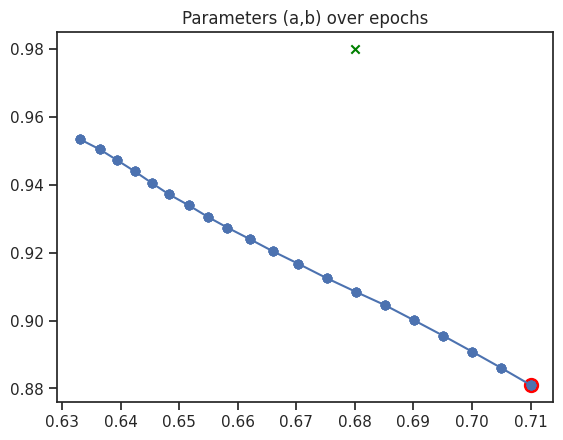

In [61]:
a_history = [p['params_a'] for p in tuner.param_history]
b_history = [p['params_b'] for p in tuner.param_history]
plt.plot(a_history, b_history, marker = 'o')
plt.scatter(params_init[0], params_init[1], marker='o', s=100, color="red", label="Base")
plt.scatter(0.68, 0.98, marker='x', color="green", label="Truth")
plt.title("Parameters (a,b) over epochs")

Flow Plots

In [56]:
# Define a grid of initial parameters
a_range  = (0.6, 0.80)
b_range  = (0.85, 1.05)
n_points = 10
a_b_init = a_b_grid(a_range, b_range, n_points)
a_b_gradients, loss_grid = tuner.Wasserstein_flow(train_loader, a_b_init)

Wasserstein Flow: 100%|███████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


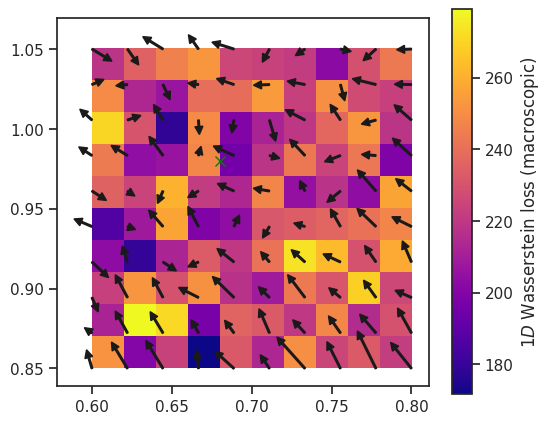

In [60]:
# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow((loss_grid * N_events).reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
#fig.colorbar(heatmap, ax=ax, label=r'$|\vec{\nabla}_\theta \mathcal{L}|$')
fig.colorbar(heatmap, ax=ax, label=r'$1D$ Wasserstein loss (multiplicity)')

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0]/1e-1, -gradient[1]/1e-1, head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='green', label = 'Target', ms = 7, linewidth=10)#label = r'$\mathrm{Target}$')
